In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from LSTM_impl import LSTM  
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
column_names = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
                'Dividends', 'Stock Splits', 'Brand_Name', 'Ticker',
                'Industry_Tag', 'Country', 'Capital Gains']

dataset = pd.read_csv('World-Stock-Prices-Dataset.csv', names=column_names, header=0, na_values='?')
dataset['Date'] = pd.to_datetime(dataset['Date'], utc=True).dt.tz_localize(None)
dataset = dataset.dropna(subset=['Close'])

dataset['Year'] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day

dataset.sort_values(by=["Ticker", "Date"], inplace=True)

sequence_length = 10
features = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'Year', 'Month', 'Day']
target_column = 'Close'
for col in features + [target_column]:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')
dataset['Dividends'] = dataset['Dividends'].fillna(0)
dataset['Stock Splits'] = dataset['Stock Splits'].fillna(0)

sequences = []
targets = []

In [3]:

for ticker in dataset['Ticker'].unique():
    ticker_df = dataset[dataset['Ticker'] == ticker]
    X = ticker_df[features].values
    y = ticker_df[target_column].values

    for i in range(len(X) - sequence_length):
        sequences.append(X[i:i+sequence_length])
        targets.append(y[i+sequence_length])

X = np.array(sequences)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_shape = X_train.shape
X_test_shape = X_test.shape

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train_shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test_shape)


Epoch 1/100, Train Loss: 24561.7866, Val Loss: 23783.8733, LR: 0.001000
Epoch 2/100, Train Loss: 23315.1335, Val Loss: 22533.1207, LR: 0.000950
Epoch 3/100, Train Loss: 21827.1352, Val Loss: 20786.2329, LR: 0.000902
Epoch 4/100, Train Loss: 20130.8129, Val Loss: 19354.8848, LR: 0.000857
Epoch 5/100, Train Loss: 18949.8137, Val Loss: 18237.9464, LR: 0.000815
Epoch 6/100, Train Loss: 17932.4167, Val Loss: 17553.8405, LR: 0.000774
Epoch 7/100, Train Loss: 17657.6894, Val Loss: 17486.5724, LR: 0.000735
Epoch 8/100, Train Loss: 17588.9191, Val Loss: 17360.3985, LR: 0.000698
Epoch 9/100, Train Loss: 17447.2779, Val Loss: 17264.3711, LR: 0.000663
Epoch 10/100, Train Loss: 17387.7709, Val Loss: 17238.1108, LR: 0.000630
Epoch 11/100, Train Loss: 17372.0448, Val Loss: 17223.2785, LR: 0.000599
Epoch 12/100, Train Loss: 17379.0860, Val Loss: 17230.0234, LR: 0.000569
Epoch 13/100, Train Loss: 17396.9308, Val Loss: 17262.0519, LR: 0.000540
Epoch 14/100, Train Loss: 17418.6587, Val Loss: 17298.3040, 

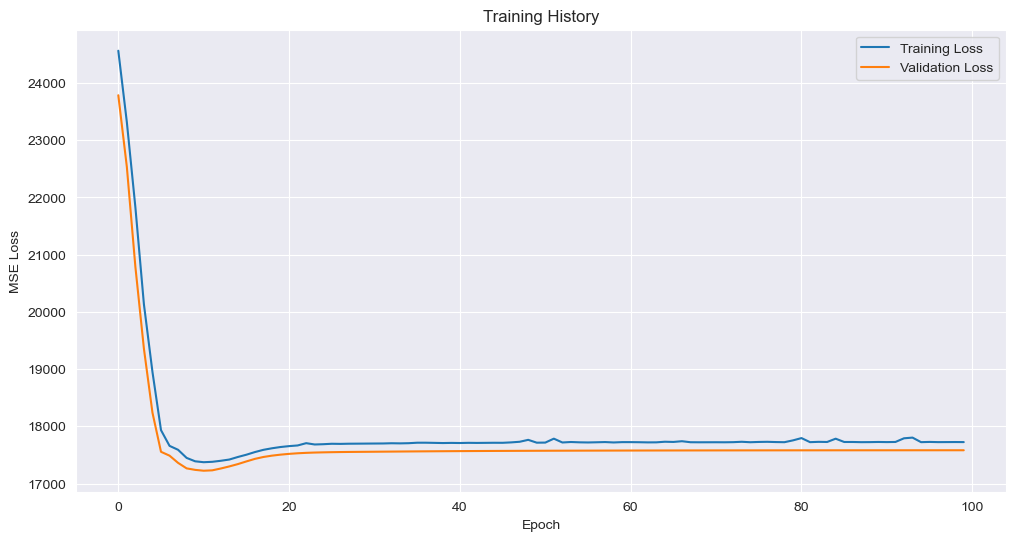

Final Test Loss: 17580.9613


In [4]:
def evaluate_model(model, X_test, y_test):
    test_loss = 0
    batch_count = 0
    for i in range(0, len(X_test), model.batch_size):
        x_batch = X_test[i:i+model.batch_size]
        y_batch = y_test[i:i+model.batch_size].reshape(-1, 1)
        loss = model.eval_step(x_batch, y_batch)
        test_loss += loss
        batch_count += 1
    return test_loss / batch_count if batch_count > 0 else 0

def train_model():
    epochs = 100
    best_loss = float('inf')
    initial_lr = 0.001
    lr_decay = 0.95

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        perm = np.random.permutation(len(X_train))
        epoch_loss = 0.0
        batch_count = 0
        lr = initial_lr * (lr_decay ** epoch)

        for i in range(0, len(X_train), custom_lstm.batch_size):
            idx = perm[i:i+custom_lstm.batch_size]
            if len(idx) == 0:
                continue
                
            x_batch = X_train[idx]
            y_batch = y_train[idx].reshape(-1, 1)
            
            loss = custom_lstm.train_step(x_batch, y_batch, lr=lr)
            epoch_loss += loss
            batch_count += 1

        val_loss = evaluate_model(custom_lstm, X_test, y_test)
        
        train_loss = epoch_loss / batch_count if batch_count > 0 else 0
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            custom_lstm.save("best_model.npz")

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {lr:.6f}")
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()

if __name__ == "__main__":
    input_size = X_train.shape[2]
    hidden_size = 128
    num_layers = 2
    batch_size = 128

    custom_lstm = LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_size=batch_size
    )

    train_model()
    final_loss = evaluate_model(custom_lstm, X_test, y_test)
    print(f"Final Test Loss: {final_loss:.4f}")
    custom_lstm.save("LSTM_optimized_v1.npz")